# Background:

A local hospital has seen an increase in elderly patient falls. This has caused a significant increase in the hospitals operating costs. They are not sure why the falls are increasing and don't have a good way to prevent them. They have hired you as a data scientist to identify what the risk factors for people falling are. They also want a way to predict if a patient will fall or not for preventative care.

# Objective:

1. Identify risk factors that are associated with falling.
2. Predict which patients will fall, not fall, or stumble.

# Data Dictionary:

Link to dataset: https://www.kaggle.com/datasets/laavanya/elderly-fall-prediction-and-detection/data?select=cStick.csv
> Each row in the dataset represents one individual.

- Distance (cm): Distance from  nearest object.

- Pressure: Monitors sudden changes in grasping pressure.

- HRV (BPM): Measures heart rate variability (HRV) in beats per minute (BPM).

- Blood Sugar Level (mg/dL): Monitors blood glucose level in milligram per deciliter

- SpO2: Monitors percent of blood oxygen saturation.

- Accelerometer: Monitors linear acceleration of the walking cane. If a +/- spike of 3-g is detected a threshold is set off to detect a fall. 0 means there was not a fall and 1 means there was a fall.

- Decision: 0 = no fall detected, 1 = stumble was detected, 2 = fall detected.

**Parameter Range for Thresholds:**

| Distance (cm) | Pressure | HRV (bpm) | Blood Sugar Level (mg/dL) | SpO2 (%) | Accelerometer | Decision
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  > 50   |   small   |  60-90    |      70-80    |  > 90  |  < threshold  |  no fall  |
|  < 30   |  medium   |  90-105   |      30-70    |  80-90  | > threshold  | stumbled  |
|  < 10   |   large   |  > 105    | < 30 or > 160 |  < 80  |  > threshold  |  fall  |

# Imports and Loading Data

In [1]:
## Imports
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
# Create an array of colors for a custom palette
colors = ['#FF7B13', '#E32A2A', '#216CD3']

# Set custom color palette
sns.set_palette(sns.color_palette(colors))

In [3]:
## Load data
df = pd.read_csv('Data/clean_fall_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2039 non-null   int64  
 1   distance (cm)              2039 non-null   float64
 2   pressure                   2039 non-null   int64  
 3   hrv (bpm)                  2039 non-null   float64
 4   blood sugar level (mg/dL)  2039 non-null   float64
 5   spo2                       2039 non-null   float64
 6   accelerometer              2039 non-null   int64  
 7   decision                   2039 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 127.6 KB


,Unnamed: 0,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
0,0,25.540,1,101.396,61.080,87.770,1,1
1,1,2.595,2,110.190,20.207,65.190,1,2
2,2,68.067,0,87.412,79.345,99.345,0,0
3,3,13.090,1,92.266,36.180,81.545,1,1
4,4,69.430,0,89.480,80.000,99.990,0,0


In [4]:
## Remove 'Unnamed: 0' column
df = df.drop(columns='Unnamed: 0')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance (cm)              2039 non-null   float64
 1   pressure                   2039 non-null   int64  
 2   hrv (bpm)                  2039 non-null   float64
 3   blood sugar level (mg/dL)  2039 non-null   float64
 4   spo2                       2039 non-null   float64
 5   accelerometer              2039 non-null   int64  
 6   decision                   2039 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 111.6 KB


,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
0,25.540,1,101.396,61.080,87.770,1,1
1,2.595,2,110.190,20.207,65.190,1,2
2,68.067,0,87.412,79.345,99.345,0,0
3,13.090,1,92.266,36.180,81.545,1,1
4,69.430,0,89.480,80.000,99.990,0,0


# Functions

In [5]:
def plot_hist_boxplot(df, col, bins):
    """
    Plots a histogram and boxplot on the same x-axis for a specified
    dataframe column.
    
    Parameters:
    df: name of pandas dataframe.
    col (str): column name in pandas dataframe that will be plotted.
    bins (int): Adjusts number of bins in the histogram.
    """
    ## Subplots configuration
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)
    
    ## Setting the title at the top of the figure
    fig.suptitle(f'Histogram & Boxplot of: {col}', fontsize=24)
    
    ## Calculate the mean
    col_mean = df[col].mean()
    
    ## Calulate the median
    col_med = df[col].median()
    
    ## Histogram
    sns.histplot(data=df, x=col, bins=bins, kde=True, ax=ax[0])
    ax[0].lines[0].set_color('red')
    ax[0].axvline(col_mean, color='red', linestyle='--', label='Mean')
    ax[0].axvline(col_med, color='blue', label='Median')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('frequency')
    ax[0].legend()
        
    ## Boxplot
    sns.boxplot(data=df, x=df[col], ax=ax[1])
    ax[1].axvline(col_mean, color='red', linestyle='--')
    ax[1].lines[4].set_color('blue')

In [6]:
def bar_plot(df, col):
    """
    Plots a bar plot showing the percentages of the target feature for each
    categorical feature
    """
    ## Barplots
    ax = sns.barplot(x=df[col].value_counts().index,
                      y=df[col].value_counts(normalize=True) * 100)
    ax.set_ylabel('percentage', fontsize='18')
    ax.set_xlabel('decision', fontsize='18')
    plt.title(col, fontsize='24')
    plt.tight_layout()
    
    ## Add percentage annotations on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height,
                '{:1.2f}%'.format(height), ha='center', va='bottom',
                   weight='heavy', fontsize='x-large')

In [7]:
def plot_multiple_boxplots(df, x_col, y_cols, figsize=(10, 6)):
    """
    Plots multiple boxplots on the same plot for specified columns of a pandas DataFrame.

    Parameters:
    df: The input DataFrame.
    x_col (str): The name of the column to be used for the x-axis.
    y_cols (list): List of column names whose values will be used for the boxplots.
    figsize (tuple): The figure size, default is (10, 6).
    """
    ## Check if the specified columns exist in the DataFrame
    if x_col not in df.columns or any(col not in df.columns for col in y_cols):
        raise ValueError('Specified x_col or one of the y_cols is not in the DataFrame.')

    ## Melt the DataFrame to long format
    melted_df = pd.melt(df, id_vars=[x_col], value_vars=y_cols, var_name='Variable', value_name='Value')
    
    ## Create an array of colors for a custom palette
    colors_box = ['#FF7B13', '#E32A2A', '#216CD3', '#FFF74E']

    ## Set the figure size
    plt.figure(figsize=figsize)

    ## Create the boxplot
    sns.boxplot(x=x_col, y='Value', hue='Variable', data=melted_df, palette=colors_box)

    ## Adding labels and title
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.title(f'Boxplots of {", ".join(y_cols)} categorized by {x_col}')

# Understanding the Data

In [8]:
## Display dataframe information and first 5 rows
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance (cm)              2039 non-null   float64
 1   pressure                   2039 non-null   int64  
 2   hrv (bpm)                  2039 non-null   float64
 3   blood sugar level (mg/dL)  2039 non-null   float64
 4   spo2                       2039 non-null   float64
 5   accelerometer              2039 non-null   int64  
 6   decision                   2039 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 111.6 KB


,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
0,25.540,1,101.396,61.080,87.770,1,1
1,2.595,2,110.190,20.207,65.190,1,2
2,68.067,0,87.412,79.345,99.345,0,0
3,13.090,1,92.266,36.180,81.545,1,1
4,69.430,0,89.480,80.000,99.990,0,0


In [9]:
## Shape of the data
df.shape

(2039, 7)

> There are 2039 rows and 7 columns in the dataset.

In [10]:
## Statistical summary of the data
df.describe()

,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer,decision
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000
mean,28.694527,0.988720,95.657002,72.909243,83.563649,0.661599,0.988720
std,23.773644,0.815918,17.576499,46.940110,11.111592,0.473282,0.815918
min,0.000000,0.000000,60.000000,10.000000,60.000000,0.000000,0.000000
25%,7.642500,0.000000,82.418000,40.230000,75.285000,0.000000,0.000000
50%,20.560000,1.000000,97.238000,69.960000,85.280000,1.000000,1.000000
75%,55.205500,2.000000,109.695000,77.612500,92.692500,1.000000,2.000000
max,69.981000,2.000000,124.980000,179.293000,99.990000,1.000000,2.000000


- The pressure and decision columns only have values of 0, 1, 2, which is expected.

- The accelerometer column only has values of 0 and 1, which is expected.

- The minimum value for the distance column is 0 cm and the maximum value is 69.98 cm. It is still unclear what distance this feature is measuring. This will be explored during EDA.

- In the blood sugar level column there is a huge range between the 75th percentile and the max value. This will be explored further and adjusted if necessary.

- The minimum values for blood sugar levels and spo2 and both extremely low, to the point that in those conditions it would be considered a medical emergency.

In [28]:
df_target_group = df.groupby('decision').mean().round(2)
df_target_group

,distance (cm),pressure,hrv (bpm),blood sugar level (mg/dL),spo2,accelerometer
decision,,,,,,
0,59.99,0.0,75.16,75.16,95.16,0.0
1,20.21,1.0,97.49,50.42,85.10,1.0
2,5.00,2.0,114.99,93.57,69.99,1.0


# Univariate Analysis

## Continuous Features

### Distance (cm)

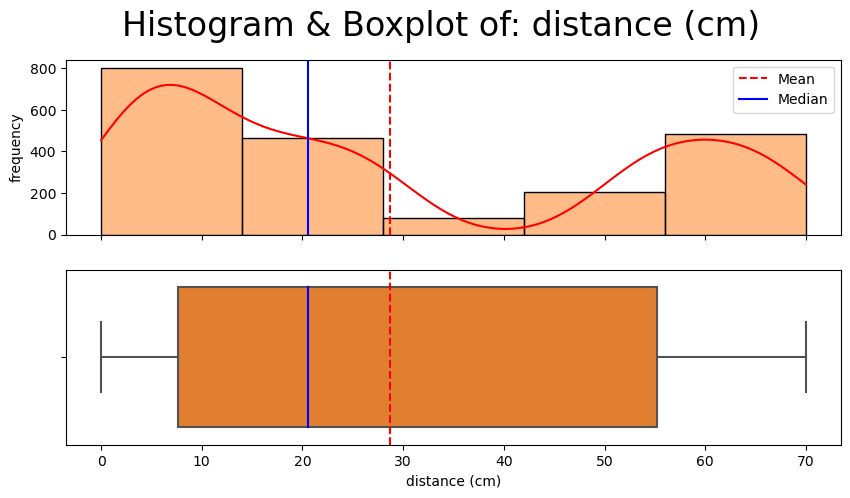

In [11]:
plot_hist_boxplot(df, 'distance (cm)', 5)
plt.savefig('Visuals/dist_hist_box.png')

> - Resembles bimodal distribution with right skew.
> - Most of the distances are between 0 cm to 15 cm with another peak at the tail of the data between 55 cm to 70 cm.
> - The range of distances is quite spread (0 cm to 70 cm) and has two distinct groups at the low and high ranges of the distribution.

### HRV (bpm)

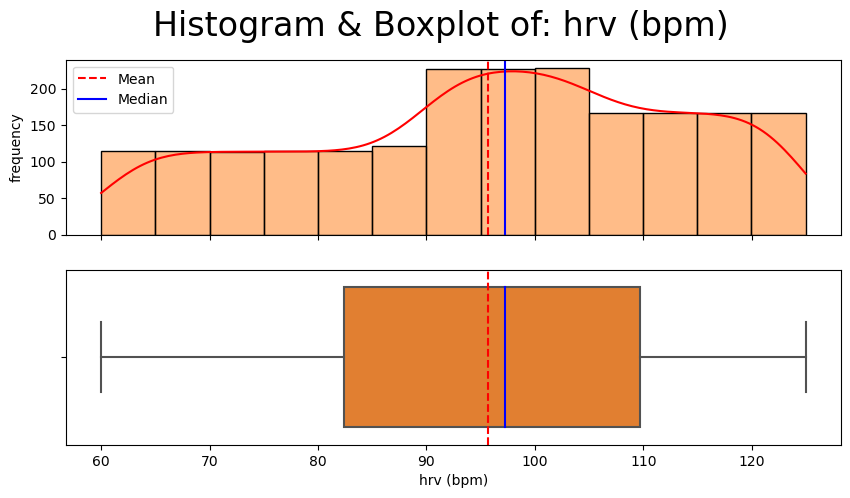

In [12]:
plot_hist_boxplot(df, 'hrv (bpm)', 13)
plt.savefig('Visuals/hrv_hist_box.png')

> - Resembles fairly uniform data with a peak around the middle of the distribution.
> - Most of the heart beat readings occur between 90 bpm to 105 bpm.
> - The mean and median are close which suggests a somewhat normal distribution.

### Blood Sugar Level (mg/dL)

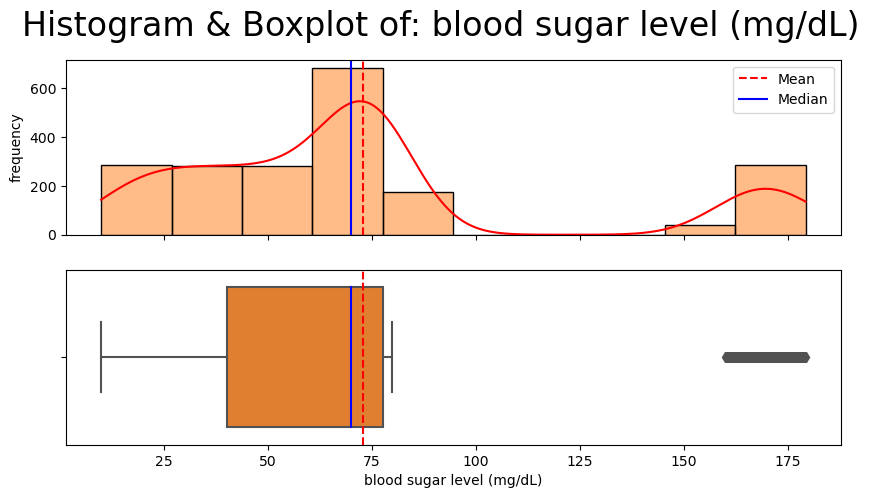

In [13]:
plot_hist_boxplot(df, 'blood sugar level (mg/dL)', 10)
plt.savefig('Visuals/bloodsugar_hist_box.png')

> - Resembles bimodal distribution with significant outliers skewing the data to the right.
> - The proximity of the mean and median suggests the outliers are significant enough to make the data appear normal just looking at the mean and median.
> - There is a large peak ranging from approx. 60 mg/dL to 85 mg/dL.
> - The boxplot suggests that most of the data is distributed in the upper quartile ranges.

### SpO2

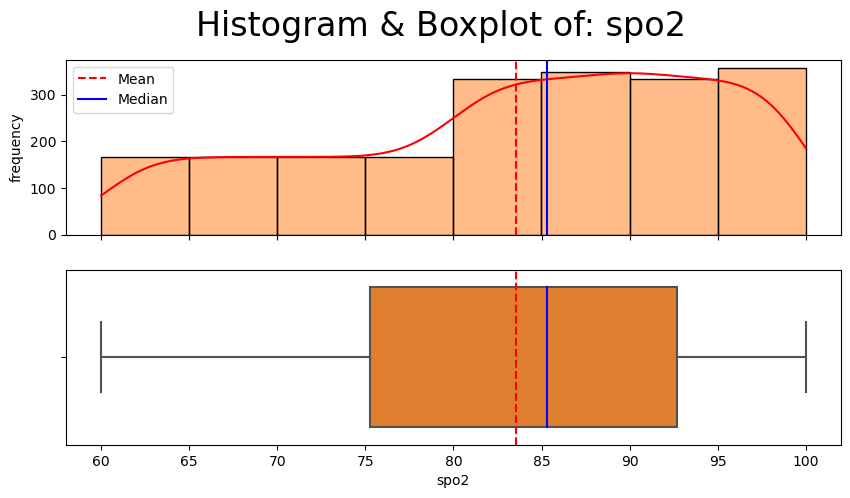

In [14]:
plot_hist_boxplot(df, 'spo2', 8)
plt.savefig('Visuals/spo2_hist_box.png')

> - Resembles relatively uniform distribution with left skew.
> - There seems to be two distinct groups. Group 1 ranges from 60% to 80% oxygen saturation. Group 2 ranges from 80% to 100% oxygen saturation.

## Categorical Features

### Pressure

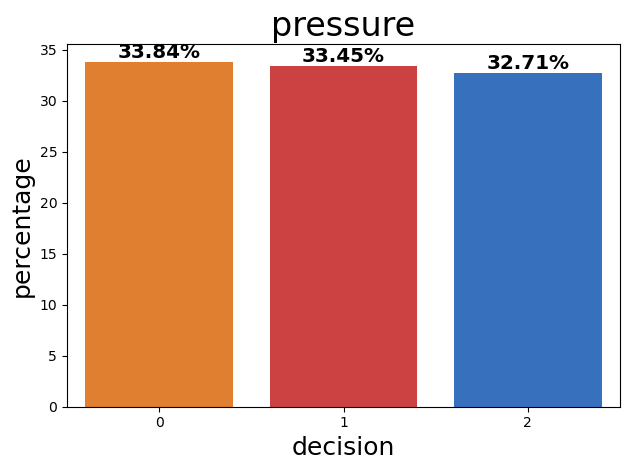

In [15]:
bar_plot(df, 'pressure')
plt.savefig('Visuals/pressure_bar.png')

> - The unique values within the pressure column are well-balanced.

### Accelerometer

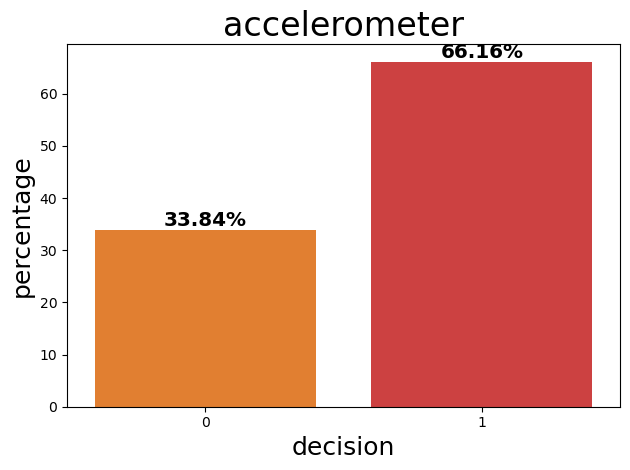

In [16]:
bar_plot(df, 'accelerometer')
plt.savefig('Visuals/accelerometer_bar.png')

> - The accelerometer column only includes two classes of the target, 0 (accelerometer not triggered) and 1 (accelerometer triggered). The two classes are unbalanced.

### Decision (Target)

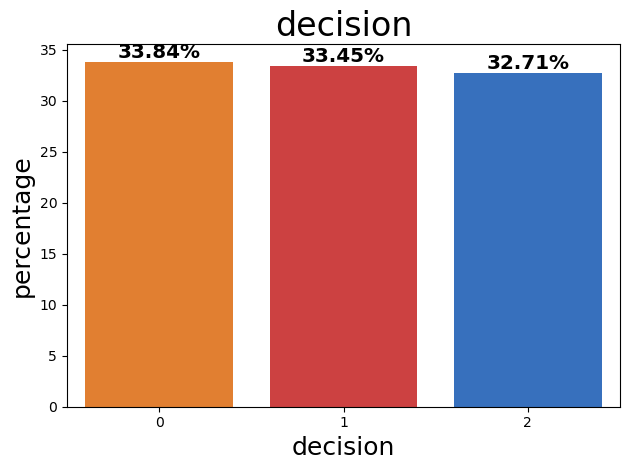

In [17]:
bar_plot(df, 'decision')
plt.savefig('Visuals/decision_bar.png')

> - The target feature is well balanced. The pressure column has the exact same balance for each class as the target feature.

# Bivariate Analysis

## Correlation Matrix

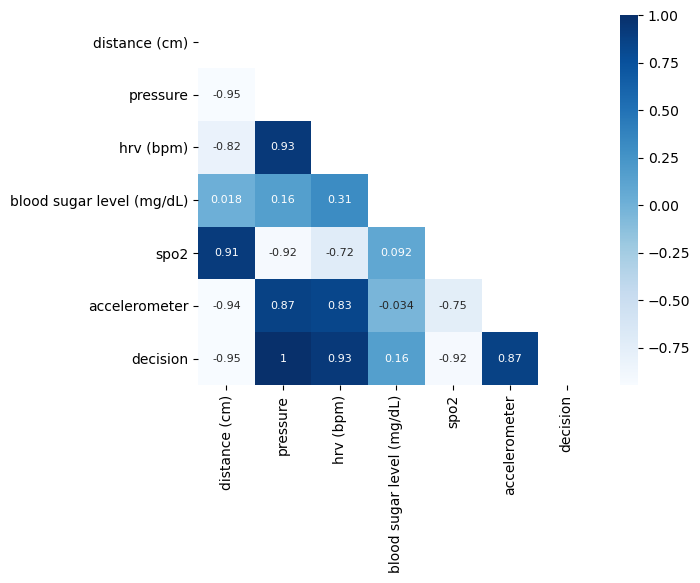

In [18]:
# Create correlation heatmap
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, cmap='Blues', annot=True, annot_kws={'size':8}, mask=mask)
plt.xticks(rotation=90)
plt.yticks(rotation=0);
plt.savefig('Visuals/heatmap.png')

> - Many of the independent variables are highly correlated introducing multicollinearity into the data.
> - Distance (cm) and SpO2 are inversely correlated with the target.
> - Pressure is perfectly correlated with the target. This should be explored to determine why this correlation exists.

## Physiological Features

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance (cm)              2039 non-null   float64
 1   pressure                   2039 non-null   int64  
 2   hrv (bpm)                  2039 non-null   float64
 3   blood sugar level (mg/dL)  2039 non-null   float64
 4   spo2                       2039 non-null   float64
 5   accelerometer              2039 non-null   int64  
 6   decision                   2039 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 111.6 KB


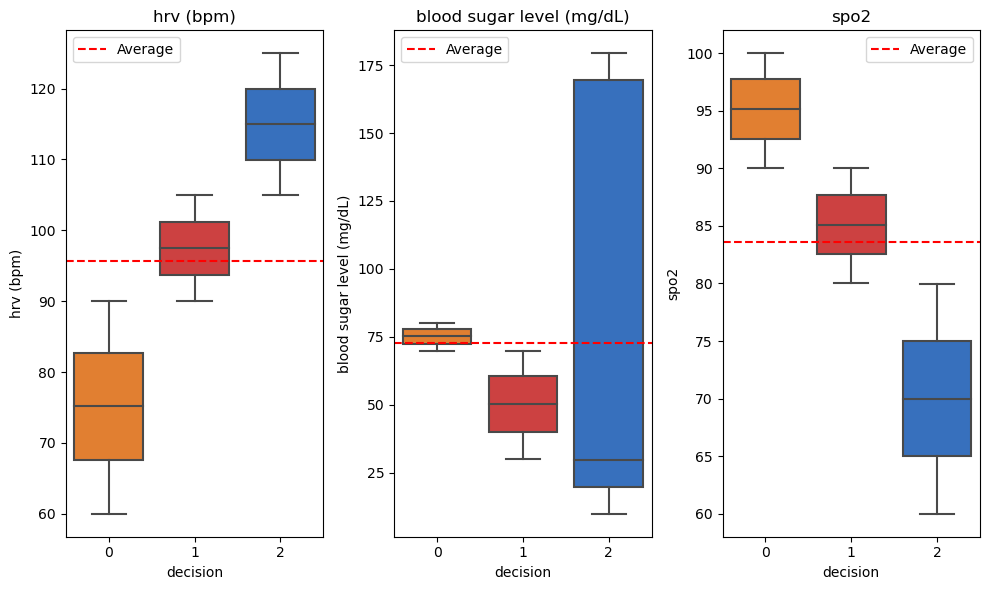

In [20]:
## Subplots configuration
fig, ax = plt.subplots(1,3, figsize=(10,6))

cols = df[['hrv (bpm)','blood sugar level (mg/dL)','spo2']]
if not isinstance(ax, np.ndarray):
    ax = [ax]

for ax, col in zip(ax, cols):
    sns.boxplot(x=df['decision'], y=df[col], ax=ax)
    ax.set_title(col)
    
    ## Calculate and add the average line for the entire dataset for each subplot
    mean_val = df[col].mean()
    ax.axhline(mean_val, color='r', linestyle='--', label='Average')

    ## Add legend to the subplot
    ax.legend()
    
plt.tight_layout()
plt.show();
fig.savefig('Visuals/physio_box.png')

> - As heart rate rises and SpO2 decreases you are more likely to fall.
> - There appears to be thresholds for both hrv (bpm) and spo2.
> - Blood sugar level has a small range for non-fallers with the range increasing for stumblers and greatly increasing for fallers.

## Non-Physiologic Features

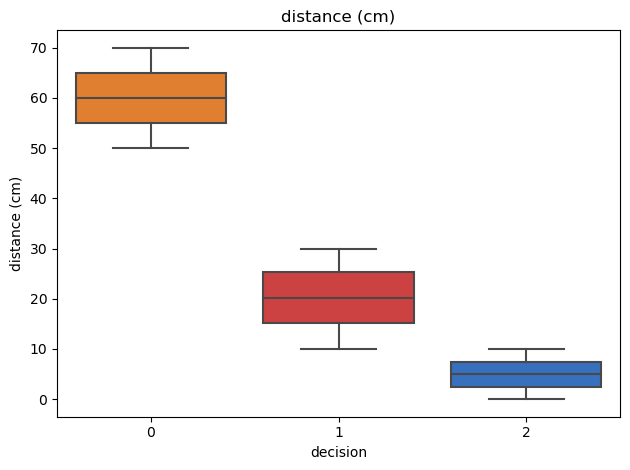

In [21]:
sns.boxplot(x=df['decision'], y=df['distance (cm)']).set_title('distance (cm)')

plt.tight_layout()
plt.show();

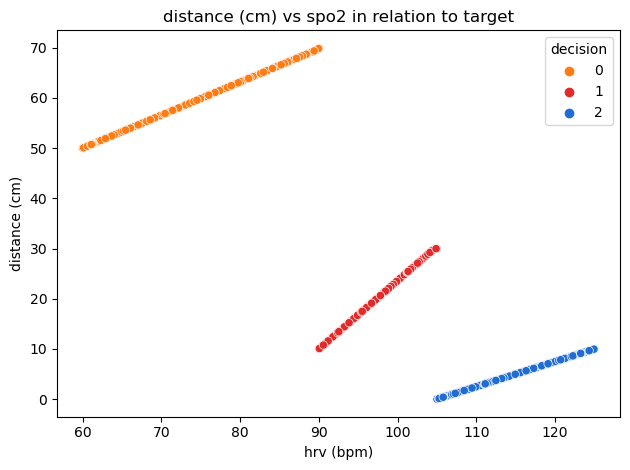

In [22]:
sns.scatterplot(x=df['hrv (bpm)'], y=df['distance (cm)'], hue=df['decision'],
               palette=colors).set_title('distance (cm) vs spo2 in relation to target')

plt.tight_layout()
plt.show();

# Multivariate

C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\seaborn\distributi

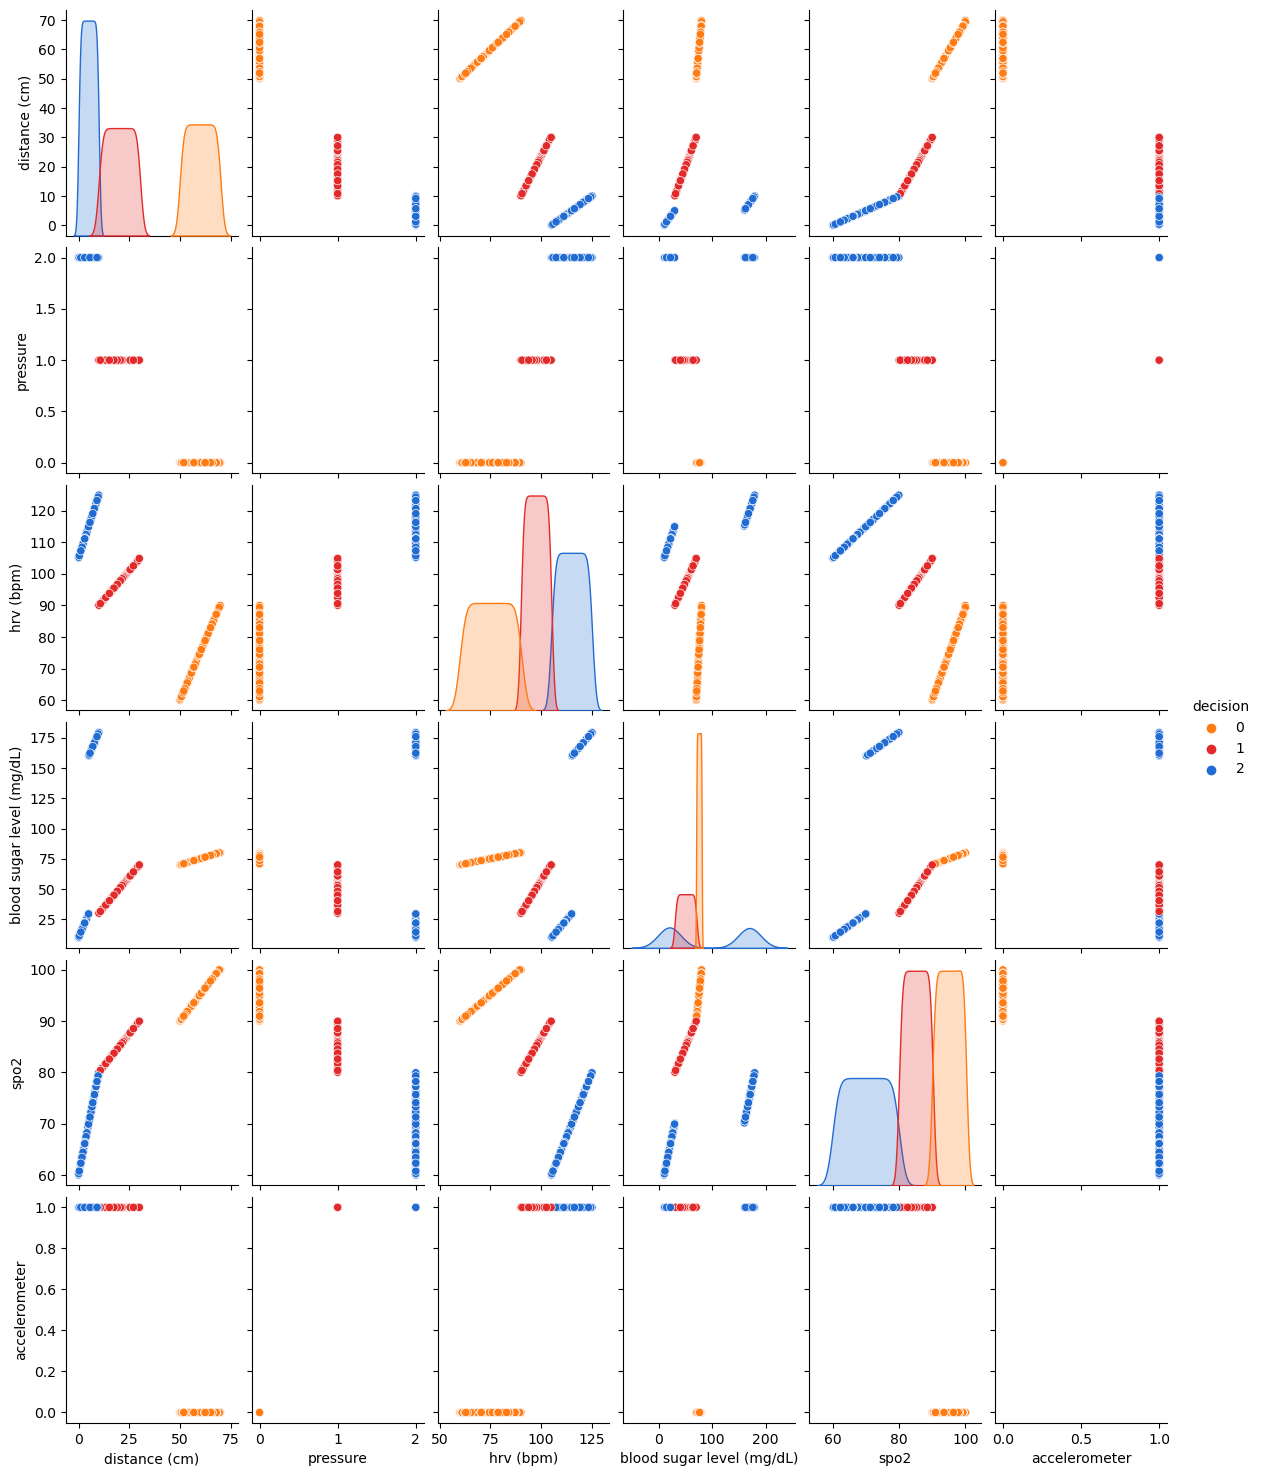

In [23]:
sns.pairplot(data=df, hue='decision', palette=colors, height=2.5, aspect=.8);

> We can see defined relationships which is in-line with the correlation matrix.

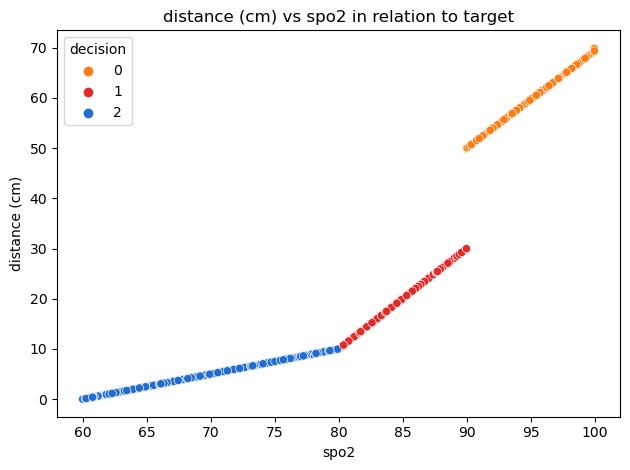

In [24]:
sns.scatterplot(x=df['spo2'], y=df['distance (cm)'], 
            hue=df['decision'], palette=colors).set_title('distance (cm) vs spo2 in relation to target')

plt.tight_layout()
plt.show();

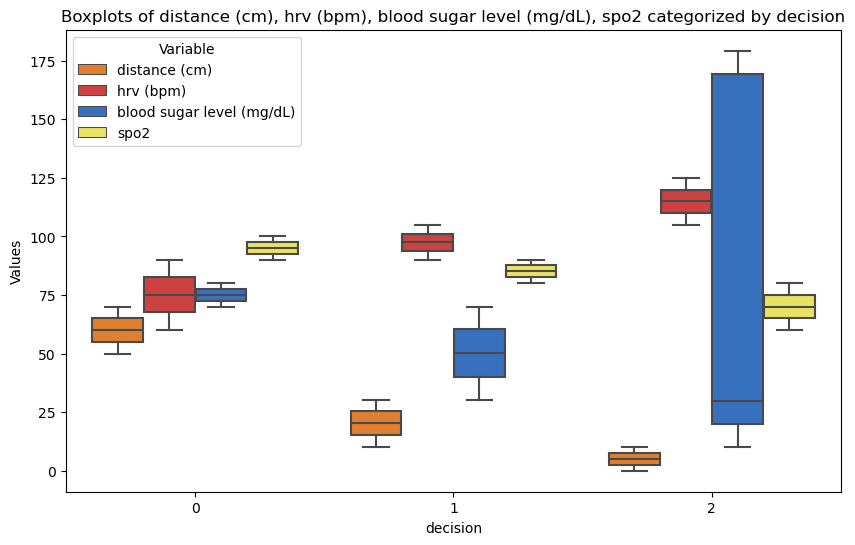

In [25]:
plot_multiple_boxplots(df, 'decision', ['distance (cm)','hrv (bpm)',
                                       'blood sugar level (mg/dL)', 'spo2'])
plt.savefig('Visuals/continuous_box.png')

> There are well defined thresholds in all features, excluding blood sugar level (mg/dL). We know that the range for blood sugar is so large from people falling with extremely low or high blood sugar level.

# Summary of EDA

## Data Description:

- There are 2039 rows and 7 columns. Each row represents 1 person. This dataset is limited in its size.

- There are no missing values in the data.

- Continuous features are float64 dtype and one hot encoded features are int64 dtype.

## Observations from EDA:

- **Distance (cm):** Resembles bimodal distribution with right skew. Strong inverse correlation with the target. 

- **HRV (BPM):** Fairly uniform with most heart rate readings occurring between 90-105 bpm. Strong correlation with the target.

- **Blood Sugar Level (mg/dL):**  bimodal with outliers skewing data to the right. Very weak correlation with the target.

- **SpO2:** Relative uniform distribution with left skew. There seems to be two distinct groups. Group 1 ranges from 60% to 80% oxygen saturation. Group 2 ranges from 80% to 100% oxygen saturation. Strong inverse correlation with the target.

- **Pressure:** Balanced observations in the target class. 33.84% occurring in small pressure, 33.45% occurring in medium pressure, and 32.71% occurring in large pressure. Perfect correlation with the target.

- **Accelerometer:** Only 2 classes. 66.16% of the observations occurred in the stumbled class. There are no observations for a confirmed fall. Strong correlation with the target.

- **Decision:** Target feature is well-balanced.

**Characteristics Non-Fallers**

-  The distance from the nearest object will be above 50 cm.

- Heart rate on average will be 75 bpm.

- Blood glucose level on average will be 75 mg/dL and will not be much higher or lower.

- Light pressure will be applied to the Cstick.

- The accelerometer will not be triggered.

- SpO2 will be above 90%.

**Characteristics Stumblers**

- The distance from the nearest object will be below 50 cm and above 10 cm.

- Heart rate will be between 90-105 bpm.

- Blood glucose level on average will be 50 mg/dL.

- Medium pressure will be applied to the Cstick.

- The accelerometer will be triggered.

- SpO2 will be between 80-90%.

**Characteristics Fallers**

- The distance from the nearest object will be less than 10 cm.

- Heart rate will be above 105 bpm.

- Blood glucose level will be lower than approx. 30 mg/dL or above approx. 90 mg/dL.

- Large pressure will be applied to the Cstick.

- SpO2 will be below 80%.




